This notebook is used to get residence-time distribution (RTD) for the entire aquifer from an existing MODFLOW model. It is possible to read in any group or label from a 3D array and make RTDs for those groups. The approach is to 
* read an existing model
* create flux-weighted particle starting locations in every cell
* run MODPATH and read endpoints
* fit parametric distributions

This notebook fits parametric distributions. Another notebook creates flux-weighted particles.

### PFJ updates:

1. Process flux and volumetrically-weighted particles at the same time.
2. Process all 3 FWP models at the same time
3. Plot results of all 6 RTDs on the same graph to generate figure 2 of the paper.

In [1]:
__author__ = 'Jeff Starn'
%matplotlib notebook

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import Image
from IPython.display import Math
from ipywidgets import interact, Dropdown
from IPython.display import display

import os
import sys
import shutil
import pickle
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.patches as patches

import flopy as fp
import imeth
import fit_parametric_distributions
import pandas as pd
import gdal
import scipy.stats as ss
import scipy.optimize as so
from scipy.interpolate import Rbf
from scipy.interpolate import griddata


# Preliminary stuff

## Set user-defined variables

MODFLOW and MODPATH use elapsed time and are not aware of calendar time. To place MODFLOW/MODPATH elapsed time on the calendar, two calendar dates were specified at the top of the notebook: the beginning of the first stress period (`mf_start_date`) and when particles are to be released (`mp_release_date`). The latter date could be used in many ways, for example to represent a sampling date, or it could be looped over to create a time-lapse set of ages. 

In [2]:
# Additional input by PFJ to run analyses of multiple models:

simulate_list = ['FWP1L_zK', 'FWP5L_zK', 'FWP5L_hK']  # list of models in the gen_mod_dict.py file to analyze


## Loop through home directory to get list of name files

In [104]:
homes = ['../Models']
fig_dir = '../Figures'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)  # PFJ:  dst is not defined; changed to fig_dir.

mfpth = '../executables/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe'
mp_exe_name = '../executables/modpath.6_0/bin/mp6x64.exe' 

mf_start_date_str = '01/01/1900' 
mp_release_date_str = '01/01/2017' 

age_cutoff = 65
year_cutoff = '01/01/1952'

surf_aq_lays = 3  # deepest layer of the surficial aquifer.

dir_list = []
mod_list = []
i = 0
r = 0

for home in homes:
    if os.path.exists(home):
        for dirpath, dirnames, filenames in os.walk(home):
            for f in filenames:
                if os.path.splitext(f)[-1] == '.nam':
                    mod = os.path.splitext(f)[0]
                    i += 1
                    if mod in simulate_list:
                        mod_list.append(mod)
                        dir_list.append(dirpath)
                        r += 1
                               
print('    {} models read'.format(i))
print('These {} models will be analyzed: {}'.format(r, mod_list))

    19 models read
These 3 models will be analyzed: ['FWP1L_zK', 'FWP5L_hK', 'FWP5L_zK']


##  Create names and path for model workspace. 

The procedures in this notebook can be run from the notebook or from a batch file by downloading the notebook as a Python script and uncommenting the following code and commenting out the following block. The remainder of the script has to be indented to be included in the loop.  This may require familiarity with Python. 

In [5]:
# generate list of nam files:
nam_list = []
for pth in dir_list:
    model = os.path.normpath(pth).split(os.sep)[2]
    nam_file = '{}.nam'.format(model)
    nam_list.append(nam_file)

# Load an existing model

In [30]:
# Read-in model info and check max/min nlay & create list of DIS objects.  
# Assumes all else is the same among models (hnoflow, hdry, etc)
print ('Reading model information')
nlay_min = 100
nlay_max = 0

dis_objs = []
for i, model in enumerate(nam_list):
    nam_file = model
    model_ws = dir_list[i]
    
    fpmg = fp.modflow.Modflow.load(nam_file, model_ws=model_ws, exe_name=mfpth, version='mfnwt', 
                                   load_only=['DIS', 'BAS6', 'UPW', 'OC'], check=False)

    dis = fpmg.get_package('DIS')
    dis_objs.append(dis)
    bas = fpmg.get_package('BAS6')
    upw = fpmg.get_package('UPW')
    oc = fpmg.get_package('OC')

    delr = dis.delr
    delc = dis.delc
    nlay = dis.nlay
    nrow = dis.nrow
    ncol = dis.ncol
    bot = dis.getbotm()
    top = dis.gettop()

    hnoflo = bas.hnoflo
    ibound = np.asarray(bas.ibound.get_value())
    hdry = upw.hdry
    
    if nlay > nlay_max:
        nlay_max = nlay
    if nlay < nlay_min:
        nlay_min = nlay
        
    print('  .. done reading model {}'.format(i+1))

print ('   ... all done') 

print('minimum layers in a model:  {}'.format(nlay_min))
print('maximum layers in a model:  {}'.format(nlay_max))

Reading model information


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\flopy\utils\util_array.py:2433: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if bintype is not None and not np.issubdtype(dtype, np.int):


  .. done reading model 1
  .. done reading model 2
  .. done reading model 3
   ... all done
minimum layers in a model:  1
maximum layers in a model:  5


## Specification of time in MODFLOW/MODPATH

There are several time-related concepts used in MODPATH.
* `simulation time` is the elapsed time in model time units from the beginning of the first stress period
* `reference time` is an arbitrary value of `simulation time` that is between the beginning and ending of `simulation time`
* `tracking time` is the elapsed time relative to `reference time`. It is always positive regardless of whether particles are tracked forward or backward
* `release time` is when a particle is released and is specified in `tracking time`

In [9]:
# setup dictionaries of the MODFLOW units for proper labeling of figures.
lenunit = {0:'undefined units', 1:'feet', 2:'meters', 3:'centimeters'}
timeunit = {0:'undefined', 1:'second', 2:'minute', 3:'hour', 4:'day', 5:'year'}

# Create dictionary of multipliers for converting model time units to days
time_dict = dict()
time_dict[0] = 1.0 # undefined assumes days, so enter conversion to days
time_dict[1] = 24 * 60 * 60
time_dict[2] = 24 * 60
time_dict[3] = 24
time_dict[4] = 1.0
time_dict[5] = 1.0

In [10]:
# convert string representation of dates into Python datetime objects
mf_start_date = dt.datetime.strptime(mf_start_date_str , '%m/%d/%Y')
mp_release_date = dt.datetime.strptime(mp_release_date_str , '%m/%d/%Y')

# convert simulation time to days from the units specified in the MODFLOW DIS file
sim_time = np.append(0, dis.get_totim())
sim_time /= time_dict[dis.itmuni]

# make a list of simulation time formatted as calendar dates
date_list = [mf_start_date + dt.timedelta(days = item) for item in sim_time]

# reference time and date are set to the end of the last stress period
ref_time = sim_time[-1]
ref_date = date_list[-1]

# release time is calculated in tracking time (for particle release) and 
# in simulation time (for identifying head and budget components)
release_time_trk = np.abs((ref_date - mp_release_date).days)
release_time_sim = (mp_release_date - mf_start_date).days

## Read endpoint file

In [45]:
def purge(ep_data):
    pre_Quaternary = ep_data.loc[ep_data.rt>=2.6e6]
    pre_Cretaceous = ep_data.loc[ep_data.rt>=66e6]
    preCambrian = ep_data.loc[ep_data.rt>=541e6]
    pre_earth = ep_data.loc[ep_data.rt>=4.6e9]

    print('\nFor your information:')
    print('{} particles were simulated as being older than Earth!'.format(preCambrian.shape[0]))
    print('{} particles were simulated as being PreCambrian in age.'.format(preCambrian.shape[0]))
    print('{} particles were simulated as being Cretaceous in age or older.'.format(pre_Cretaceous.shape[0]))
    print('{} particles were simulated as being pre-Quaternary in age.'.format(pre_Quaternary.shape[0]))
    
    ep_data = ep_data.loc[ep_data.rt<4.6e9]
    print('Purged particles older than earth')
    return(ep_data)

In [129]:
#  Change this block to read-in EPT, save-down pickles of end point file df, and generate CFD plots.  See code block 8 of GM_6flux_scale_analysis.ipynb
dfdict = {}

for i, model in enumerate(mod_list):
    model_ws = dir_list[i]
    dis = dis_objs[i]
    for group in zone_df:
        print('\nAnalyzing EPT for {}'.format(model))
        
        # form the path to the endpoint files
        mpname_flux = '{}_flux_{}'.format(os.path.join(model_ws, model), group)
        mpname_vol = '{}_volume_{}'.format(os.path.join(model_ws, model), group)
        mflux = '{}_flux'.format(model)
        mvol = '{}_volume'.format(model)

        flux_endpoint_file = '{}.{}'.format(mpname_flux, 'mpend')
        vol_endpoint_file = '{}.{}'.format(mpname_vol, 'mpend')

        # read the endpoint file to generate a dataframe
        f_ep_data1 = fit_parametric_distributions.read_endpoints(flux_endpoint_file, dis, time_dict)
        v_ep_data1 = fit_parametric_distributions.read_endpoints(vol_endpoint_file, dis, time_dict)
        
        # keep just particles that started in the surficial aquifer
        fepd = f_ep_data1[f_ep_data1['Initial Layer'] <= surf_aq_lays]
        vepd = v_ep_data1[v_ep_data1['Initial Layer'] <= surf_aq_lays]
        
        f_ep_data = purge(fepd)
        v_ep_data = purge(vepd)
        
        fdst = '{}_mod.pickle'.format(os.path.join(mpname_flux))
        pickle.dump(f_ep_data, open(fdst, 'wb'))
        vdst = '{}_mod.pickle'.format(os.path.join(mpname_vol))
        pickle.dump(v_ep_data, open(vdst, 'wb'))
        
        dfdict[mflux] = f_ep_data
        dfdict[mvol] = v_ep_data


Analyzing EPT for FWP1L_zK

For your information:
0 particles were simulated as being older than Earth!
0 particles were simulated as being PreCambrian in age.
0 particles were simulated as being Cretaceous in age or older.
0 particles were simulated as being pre-Quaternary in age.
Purged particles older than earth

For your information:
104791 particles were simulated as being older than Earth!
104791 particles were simulated as being PreCambrian in age.
108053 particles were simulated as being Cretaceous in age or older.
112731 particles were simulated as being pre-Quaternary in age.
Purged particles older than earth

Analyzing EPT for FWP5L_hK

For your information:
6 particles were simulated as being older than Earth!
6 particles were simulated as being PreCambrian in age.
6 particles were simulated as being Cretaceous in age or older.
6 particles were simulated as being pre-Quaternary in age.
Purged particles older than earth

For your information:
0 particles were simulated as b

## Plot CDFs for each model

<IPython.core.display.Javascript object>


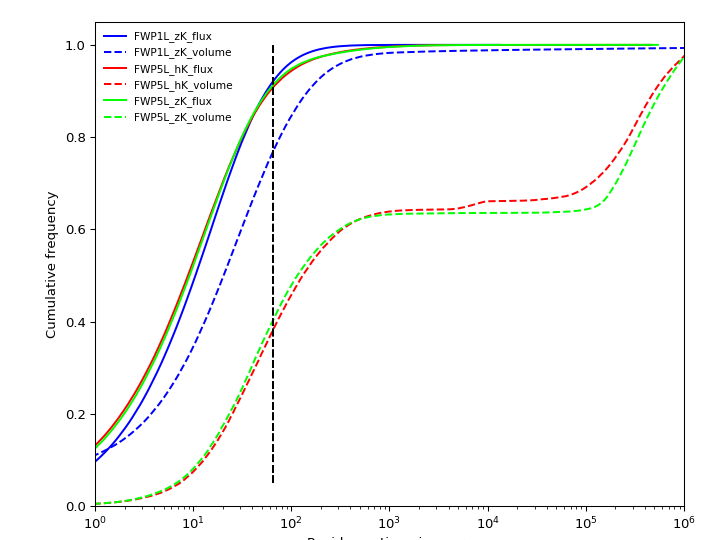

In [134]:
# Plot age distributions for all 3 models by flux/vol weight.

uniques = dfdict.keys()
n_uni = len(uniques)
sum_p = {}
for mn in uniques:
    sum_p[mn] = 0
    
vplots = 1
hplots = 1
figsize = (8, 6)
CS, ax = plt.subplots(vplots, hplots, figsize=figsize)

colors_line = plt.cm.brg(np.linspace(0, 1, len(mod_list)))  # 1 color for each model (3)
colors_line = colors_line.repeat(2, axis=0)  # dimensioned to account for flux and vol for each model
linestyle = []
for i, md in enumerate(uniques):
    
    if 'flux' in md:
        linestyle = '-'
    else:
        linestyle = '--'

    rt = dfdict[md].rt.copy()  # 'rt' is "raw time" in the dataframe
    rt.sort_values(inplace=True)
    sum_p[md] = sum_p[md] + rt.count()
    y_rt = np.linspace(0, 1, rt.shape[0])

    ax.plot(rt, y_rt, c=colors_line[i], linestyle=linestyle, label=md)
    ax.plot((65, 65), (0.05, 1), 'k--')

    ax.set_xscale('log')
    ax.set_xlim(1e0, 1e6)
    ax.set_ylim(0, )

    ax.legend(loc=0, frameon=False, fontsize=8)#, bbox_to_anchor=(0.20, 0.2), ncol=1)
    ax.set_xlabel('Residence time, in years')
    ax.set_ylabel('Cumulative frequency')

CS.subplots_adjust(top= 0.96, hspace=0.15)

dst = '../RTD_flux_vs_vol.png'
plt.savefig(dst)
#plt.close()

In [ ]:
#dst = os.path.join(model_ws, 'RTD')
#if not os.path.exists(dst):
#    os.mkdir(dst)

In [ ]:
#src = os.path.join(model_ws, 'tau.txt')

#with open(src) as f:
#    lines = f.readlines()

#items = [item.split()[6] for item in lines]  # PFJ:  This line is failing for "All_zones".

#tau_glacial = np.float(items [0])
#tau_bedrock = np.float(items [1])
#tau_total = np.float(items [2])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

dist = dist_list[0]
uname = 'uni_{}'.format(dist.name)
aname = 'add_{}'.format(dist.name)
# iname = 'imp_{}'.format(dist.name)
fy = 0

part_tt = fit_dict[model]['tt']['rt']  # PFJ:  There is no "model" key for "all zones"
part_cdf = fit_dict[model]['tt']['rt_cdf']
ax.semilogx(np.exp(part_tt), part_cdf, label='Particle', lw=5, color='r', alpha=0.4)

try:
    ep_uni = fit_dict[model]['par'][uname]
    uni_cdf = fit_dict[model]['cdf'][uname]
    ax.plot(np.exp(part_tt), uni_cdf, label='Parametric CDF: No mixing', color='k', lw=1)
except Exception as e: 
    print(e)

# try:
#     ep_exp = fit_dict[model]['par'][iname]
#     imp_cdf = fit_dict[model]['cdf'][iname]
#     ax.plot(np.exp(part_tt), imp_cdf, label='Parametric CDF: Implicit mixing', color='g', lw=2)
# except Exception as e: 
#     print(e)

try:
    ep_exp = fit_dict[model]['par'][aname]
    fy = ep_exp[6]
    add_cdf = fit_dict[model]['cdf'][aname]
    ax.plot(np.exp(part_tt), add_cdf, label='Parametric CDF: Explicit mixing', color='r', lw=1)
except Exception as e: 
    print(e)

try:
    expon = ss.expon(np.exp(first), tau_glacial)
    exx = np.logspace(part_tt.min(), part_tt.max(), 1000)
    exy = expon.cdf(exx)
    ax.plot(exx / por, exy, label='Calculated exponential CDF', color='b', lw=1, ls='dashed')
except Exception as e: 
    print(e)

ax.set_xscale('log')
ax.set_xlim(0.05, 50000)
ax.set_ylim(0, 1)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + 0.15, box.width * 1.10, box.height * 0.8])
ax.set_ylabel('Cumulative frequency', fontsize=8)
ax.set_xlabel('Residence time / porosity, in years', fontsize=8)
ax.legend(loc=0, frameon=False, fontsize=8, handlelength=3, numpoints=1, ncol=2, 
          bbox_to_anchor=(1.0, -0.2))
ax.set_title('{2:}\n{0:} RTD with {1:0.0f}% RTD$_1$'.format(dist.name, fy*100, model),
             fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)

dst = 'Cumulative RTD for all layers and distributions--{}'.format(model)
dst_pth = os.path.join(model_ws, 'RTD', dst)
plt.savefig(dst_pth, dpi=300)
# plt.close()

In [ ]:
for zone_group in group_column_list:
    gp = ep_data.groupby(zone_group)
    for zon, j in gp:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

#         for i, ax in enumerate(axs):
        dist = dist_list[0]
        uname = 'uni_{}'.format(dist.name)
#             aname = 'add_{}'.format(dist.name)
        iname = 'imp_{}'.format(dist.name)
        fy = 0

        part_tt = fit_dict_zones[zon]['tt']['rt']
        part_cdf = fit_dict_zones[zon]['tt']['rt_cdf']
        ax.semilogx(np.exp(part_tt), part_cdf, label='Particle', lw=5, color='r', alpha=0.4)

        try:
            ep_uni = fit_dict_zones[zon]['par'][uname]
            uni_cdf = fit_dict_zones[zon]['cdf'][uname]
            ax.plot(np.exp(part_tt), uni_cdf, label='Parametric CDF: No mixing', color='k', lw=1)
        except Exception as e: 
            print(e)

#             try:
#                 ep_exp = fit_dict_zones[zon]['par'][iname]
#                 imp_cdf = fit_dict_zones[zon]['cdf'][iname]
#                 ax.plot(np.exp(part_tt), imp_cdf, label='Parametric CDF: Implicit mixing', color='g', lw=2)
#             except Exception as e: 
#                 print(e)

        try:
            ep_exp = fit_dict_zones[zon]['par'][aname]
            fy = ep_exp[6]
            add_cdf = fit_dict_zones[zon]['cdf'][aname]
            ax.plot(np.exp(part_tt), add_cdf, label='Parametric CDF: Explicit mixing', color='r', lw=1)
        except Exception as e: 
            print(e)

        try:
            expon = ss.expon(np.exp(first), tau_glacial)
            exx = np.logspace(part_tt.min(), part_tt.max(), 1000)
            exy = expon.cdf(exx)
            ax.plot(exx / por, exy, label='Calculated exponential CDF', color='b', lw=1, ls='dashed')
        except Exception as e: 
            print(e)

        ax.set_xscale('log')
        ax.set_xlim(0.05, 50000)
        ax.set_ylim(0, 1)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + 0.15, box.width * 1.10, box.height * 0.8])
        ax.set_ylabel('Cumulative frequency', fontsize=8)
        ax.set_xlabel('Residence time / porosity, in years', fontsize=8)
        ax.legend(loc=0, frameon=False, fontsize=8, handlelength=3, numpoints=1, ncol=2, 
                  bbox_to_anchor=(1.0, -0.2))
        ax.set_title('{2:} zone: {3:}\n{0:} RTD with {1:0.0f}% RTD$_1$'.format(dist.name, fy*100, model, zon), fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

        dst = 'Cumulative RTD for all distributions in zone {}--{}.png'.format(zon, model)
        dst_pth = os.path.join(model_ws, 'RTD', dst)
        plt.savefig(dst_pth, dpi=300)
        # plt.close()

## Plot PDF for explicit RTD mixtures

In [ ]:
prt = np.exp(lprt)

logbins = np.logspace(-4, 4, 100, base=np.e)
linbins = np.linspace(0.001, 1000, 100)
linbins = np.linspace(-8, 8, 100)
freq, bins = np.histogram(lprt, bins=linbins, normed=True)
bincen = 0.5 * (bins[:-1] + bins[1:])

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

dist = dist_list[0]
dname = 'add_{}'.format(dist.name)
fy = 0

ax.plot(np.exp(bincen), freq, linestyle='None', marker='.', mfc='0.20', mew=0, label='Particle RTD', ms=5)

try:
    ep_exp = fit_dict[model]['par'][dname]
    pdf_e_exp = dist(ep_exp[0], ep_exp[1], ep_exp[2]).pdf(lprt) 
    ax.plot(prt, pdf_e_exp, color='blue', linestyle='dashed', linewidth=1, label='RTD$_1$')
    mean_age_early = np.exp((lprt[1:] * pdf_e_exp[1:] * np.diff(lprt)).sum())
    ax.axvline(mean_age_early, 0, 0.1, color='blue', label='RTD$_1$ mean age', lw=2)
except Exception as e: 
    print(e)

try:
    ep_exp = fit_dict[model]['par'][dname]
    pdf_l_exp = dist(ep_exp[3], ep_exp[4], ep_exp[5]).pdf(lprt) 
    ax.plot(prt, pdf_l_exp, color='green', linestyle='dashed', linewidth=1, label='RTD$_2$')
    mean_age_late = np.exp((lprt[1:] * pdf_l_exp[1:] * np.diff(lprt)).sum())
    ax.axvline(mean_age_late, 0, 0.1, color='green', label='RTD$_2$ mean age', lw=2)
except Exception as e: 
    print(e)

try:
    ep_exp = fit_dict[model]['par'][dname]
    pdf_e_exp = dist(ep_exp[0], ep_exp[1], ep_exp[2]).pdf(lprt) 
    pdf_l_exp = dist(ep_exp[3], ep_exp[4], ep_exp[5]).pdf(lprt) 
    fy = ep_exp[6]
    combined_exp = fy * pdf_e_exp + (1 - fy) * pdf_l_exp
#         ax.plot(np.exp(lprt), combined_exp, color='r', linestyle='dashed', linewidth=1, label='RTD$_2$')
    ax.fill_betweenx(combined_exp, prt, color='r', linewidth=1, label='Composite RTD', alpha=0.3)
    mean_age_mixed = np.exp((lprt[1:] * combined_exp[1:] * np.diff(lprt)).sum())
    ax.axvline(mean_age_mixed, 0, 0.1, color='red', label='Composite mean age', lw=2)
except Exception as e: 
    print(e)

ax.set_xscale('log')
ax.set_xlim(0.05, 50000)
ax.set_ylim(0, )
box = ax.get_position()
ax.set_position([box.x0, box.y0 + 0.15, box.width * 1.10, box.height * 0.8])
if i == 0:
    ax.set_ylabel('Density in 1 / years', fontsize=8)
if i == 1:
    ax.set_xlabel('Residence time / porosity, in years', fontsize=8)
    ax.legend(loc=0, frameon=False, fontsize=8, handlelength=3, numpoints=1, ncol=3, 
              bbox_to_anchor=(1., -0.2))
ax.set_title('{2:}\n{0:} RTD with {1:0.0f}% RTD$_1$'.format(dist.name, fy*100, model), fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
    
dst = 'Explicit RTD for all layers for each cohort {}'.format(model)
dst_pth = os.path.join(model_ws, 'RTD', dst)
plt.savefig(dst_pth, dpi=300)
# plt.close()    

## Plot figure

In [ ]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 8,
        'sans-serif' : 'Arial'}

plt.rc('font', **font)


prt = np.exp(lprt)

logbins = np.logspace(-4, 4, 100, base=np.e)
linbins = np.linspace(0.001, 1000, 100)
linbins = np.linspace(-8, 8, 100)
freq, bins = np.histogram(lprt, bins=linbins, normed=True)
bincen = 0.5 * (bins[:-1] + bins[1:])

fig, ax = plt.subplots(1, 1, figsize=(3.8, 4.6))

dist = dist_list[0]
dname = 'add_{}'.format(dist.name)
fy = 0

ax.plot(np.exp(bincen), freq, linestyle='None', marker='.', mfc='0.20', mew=0, label='Particle RTD', ms=5)

try:
    ep_exp = fit_dict[model]['par'][dname]
    pdf_e_exp = dist(ep_exp[0], ep_exp[1], ep_exp[2]).pdf(lprt) 
    ax.plot(prt, pdf_e_exp, color='blue', linestyle='dashed', linewidth=1, label='RTD$_1$')
    mean_age_early = np.exp((lprt[1:] * pdf_e_exp[1:] * np.diff(lprt)).sum())
    ax.axvline(mean_age_early, 0, 0.1, color='blue', label='RTD$_1$ mean age', lw=2)
except Exception as e: 
    print(e)

try:
    ep_exp = fit_dict[model]['par'][dname]
    pdf_l_exp = dist(ep_exp[3], ep_exp[4], ep_exp[5]).pdf(lprt) 
    ax.plot(prt, pdf_l_exp, color='green', linestyle='dashed', linewidth=1, label='RTD$_2$')
    mean_age_late = np.exp((lprt[1:] * pdf_l_exp[1:] * np.diff(lprt)).sum())
    ax.axvline(mean_age_late, 0, 0.1, color='green', label='RTD$_2$ mean age', lw=2)
except Exception as e: 
    print(e)

try:
    ep_exp = fit_dict[model]['par'][dname]
    pdf_e_exp = dist(ep_exp[0], ep_exp[1], ep_exp[2]).pdf(lprt) 
    pdf_l_exp = dist(ep_exp[3], ep_exp[4], ep_exp[5]).pdf(lprt) 
    fy = ep_exp[6]
    combined_exp = fy * pdf_e_exp + (1 - fy) * pdf_l_exp
    ax.fill_betweenx(combined_exp, prt, color='r', linewidth=1, label='Explicitly mixed RTD', alpha=0.3)
    mean_age_mixed = np.exp((lprt[1:] * combined_exp[1:] * np.diff(lprt)).sum())
    ax.axvline(mean_age_mixed, 0, 0.1, color='red', label='Explicitly mixed mean age', lw=2)
except Exception as e: 
    print(e)

ax.set_xscale('log')
ax.set_xlim(1, 10000)
ax.set_ylim(0, )
box = ax.get_position()
ax.set_position([box.x0, box.y0 + 0.15, box.width * 1.10, box.height * 0.8])
ax.set_ylabel('Density in 1 / years', fontsize=8)
ax.set_xlabel('Residence time / porosity in years', fontsize=8)
# ax.legend(loc=0, frameon=False, fontsize=8, handlelength=3, numpoints=1, ncol=2, 
#           bbox_to_anchor=(1., -0.2))
ax.tick_params(axis='both', which='major', labelsize=8)
fig.set_tight_layout(True)

form_list = ['png', 'pdf']
for form in form_list:
    line = 'Paper #2017WR021531-f06.{}'.format(form)
    fig_name = os.path.join(fig_dir, line)
    plt.savefig(fig_name, dpi=300)

# Notes on RTD parent distributions

From Stack Exchange Cross Validated:

Both the gamma and Weibull distributions can be seen as generalisations of the exponential distribution. If we look at the exponential distribution as describing the waiting time of a Poisson process (the time we have to wait until an event happens, if that event is equally likely to occur in any time interval), then the $\Gamma(k, \theta)$ distribution describes the time we have to wait for $k$ independent events to occur.

On the other hand, the Weibull distribution effectively describes the time we have to wait for one event to occur, if that event becomes more or less likely with time. Here the $k$ parameter describes how quickly the probability ramps up (proportional to $t^{k−1}$).

We can see the difference in effect by looking at the pdfs of the two distributions. Ignoring all the normalising constants:

$f_\Gamma(x)\propto x^{k-1}\exp(-\frac{x}{\theta})$

$f_W(x)\propto x^{k-1}\exp(-{(\frac{x}{\lambda})^k)}$

The Weibull distribution drops off much more quickly (for $k>1$) or slowly (for $k<1$) than the gamma distribution. In the case where $k=1$, they both reduce to the exponential distribution.

From Wikipedia:

The generalized gamma has three parameters: $a>0$, $d>0$, and $p>0$. For non-negative x, the probability density function of the generalized gamma is$^{[2]}$

$f(x;a,d,p)={\frac  {(p/a^{d})x^{{d-1}}e^{{-(x/a)^{p}}}}{\Gamma (d/p)}},$

where $\Gamma (\cdot )$ denotes the gamma function.

The cumulative distribution function is
$F(x;a,d,p)={\frac  {\gamma (d/p,(x/a)^{p})}{\Gamma (d/p)}},$

where $\gamma (\cdot )$ denotes the lower incomplete gamma function.

If $d=p$ then the generalized gamma distribution becomes the Weibull distribution. Alternatively, if $p=1$ the generalised gamma becomes the gamma distribution.

From NIST National Engineering Handbook

The formula for the probability density function of the general Weibull distribution is

$f(x)=\frac\gamma\alpha(\frac{x-\mu}\alpha)^{(\gamma-1)}\exp(-(\frac{(x-\mu)}\alpha)^\gamma)$

$x\ge\mu; \gamma,\alpha>0$

where $\gamma$ is the shape parameter, $\mu$ is the location parameter and $\alpha$ is the scale parameter. The case where $\mu = 0$ and $\alpha = 1$ is called the standard Weibull distribution. The case where $\mu = 0$ is called the 2-parameter Weibull distribution. The equation for the standard Weibull distribution reduces to

$f(x)=\gamma x^{(\gamma-1)}\exp(-(x^\gamma))$

Since the general form of probability functions can be expressed in terms of the standard distribution, all subsequent formulas in this section are given for the standard form of the function.

The general formula for the probability density function of the gamma distribution is

$f(x)=\frac{(\frac{x-\mu}{\beta})^{\gamma-1}\exp(-\frac{x-\mu}{\beta})}{\beta\Gamma(\gamma)}$

where $\gamma$ is the shape parameter, $\mu$ is the location parameter, $\alpha$ is the scale parameter, and $\Gamma$ is the gamma function which has the formula

$\Gamma(a)=\int_0^\infty t^{a-1}e^{-t}dt$

The case where $\mu=0$ and $\beta=1$ is called the standard gamma distribution. The equation for the standard gamma distribution reduces to

$f(x)=\frac{x^{\gamma-1}\exp(-x)}{\Gamma(\gamma)}$

  
Since the general form of probability functions can be expressed in terms of the standard distribution, all subsequent formulas in this section are given for the standard form of the function.